In [1]:
N_NEIGHBORS = 11

# CONSTANTES CONTENT BASED

# CAMINHOS

PATH_TO_FULL_CB_FILE = "../../preprocessed-data/CB/data_cb.pkl"

PATH_TO_MOVIES_CB_FILE = "../../preprocessed-data/CB/movies_cb.pkl"

PATH_TO_RATINGS_CB_FILE = "../../preprocessed-data/CB/ratings_cb.pkl"

PATH_TO_RATINGS_INFOS_CB_FILE = "../../preprocessed-data/CB/ratings_info_cb.pkl"

PATH_TO_TAG_RELEVANCE_GROUPED_CB_FILE = "../../preprocessed-data/CB/tag_relevance_grouped_cb.pkl"

PATH_TO_TAG_RELEVANCE_CB_FILE = "../../preprocessed-data/CB/tag_relevance_cb.pkl"

PATH_TO_TAGS_PROCESSED_CB_FILE = "../../preprocessed-data/CB/tags_processed_cb.pkl"

# DataFrames Names

# data_cb = arquivo completo 
# movies_cb = arquivos de filmes
# ratings_cb = arquivos de ratings
# ratings_infos_cb = arquivos de informações sobre os ratings
# tag_relevance_grouped_cb = relevancia de tags após o agrupamento
# tag_relevance_cb = relevancia de tags original
# tags_processed_cb = tags todas juntas em uma coluna e processadas pelo nltk

In [2]:
# Importando bibliotecas necessárias
import pandas as pd
pd.set_option("display.max_rows", 25)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import sys

# Importando garbage collector
import gc

# Importando bibliotecas para o sistema de recomendação
import scipy.sparse as sparse # Matriz esparsa (csr_matrix)

# Importando sklearn
import sklearn
from sklearn.neighbors import NearestNeighbors

# Importando Regular Expression operations
import re

# 1 - Preparação dos dados para Content Based

In [3]:
def load_cb_files(full=True, movies=False, ratings=False, ratings_infos=False ,relevance_grouped=False, relevance=False, tags_processed=False):
    data_cb = None
    movies_cb = None 
    ratings_cb = None
    ratings_infos_cb = None
    tag_relevance_grouped_cb = None
    tag_relevance_cb = None
    tags_processed_cb = None
    
    # Caso se queira carregar o completo
    if(full):
        data_cb = pd.read_pickle(PATH_TO_FULL_CB_FILE)
        print("Arquivo completo: Carregado com sucesso!")
    else:
        print("Arquivo completo: Não foi carregado, verifique se era o que desejava.")
    
    # Caso queira-se carregar o arquivo de filmes
    if(movies):
        movies_cb = pd.read_pickle(PATH_TO_MOVIES_CB_FILE)
        print("Arquivo movies: Carregado com sucesso!")
    else:
        print("Arquivo movies: Não foi carregado, verifique se era o que desejava.")
        
    if(ratings):
        ratings_cb = pd.read_pickle(PATH_TO_RATINGS_CB_FILE)
        print("Arquivo ratings: Carregado com sucesso!")
    else:
        print("Arquivo ratings: Não foi carregado, verifique se era o que desejava.")
    
    if(ratings_infos):
        ratings_infos_cb = pd.read_pickle(PATH_TO_RATINGS_INFOS_CB_FILE)
        print("Arquivo ratings infos: Carregado com sucesso!")
    else:
        print("Arquivo ratings infos: Não foi carregado, verifique se era o que desejava.")
        
    if(relevance_grouped):
        tag_relevance_grouped_cb = pd.read_pickle(PATH_TO_TAG_RELEVANCE_GROUPED_CB_FILE)
        print("Arquivo relevance grouped: Carregado com sucesso!")
    else:
        print("Arquivo relevance grouped: Não foi carregado, verifique se era o que desejava.")
    
    if(relevance):
        tag_relevance_cb = pd.read_pickle(PATH_TO_TAG_RELEVANCE_CB_FILE)
        print("Arquivo relevance: Carregado com sucesso!")
    else:
        print("Arquivo relevance: Não foi carregado, verifique se era o que desejava.")
        
    if(tags_processed):
        tags_processed_cb = pd.read_pickle(PATH_TO_TAGS_PROCESSED_CB_FILE)
        print("Arquivo tags processed: Carregado com sucesso!")
    else:
        print("Arquivo tags processed: Não foi carregado, verifique se era o que desejava.")
        
        
    return data_cb, movies_cb, ratings_cb, ratings_infos_cb, tag_relevance_grouped_cb, tag_relevance_cb, tags_processed_cb
    

In [4]:
data_cb, movies_cb, ratings_cb, ratings_infos_cb, tag_relevance_grouped_cb, tag_relevance_cb, tags_processed_cb = load_cb_files(full=True, movies=True, ratings_infos=True, tags_processed=True)

Arquivo completo: Carregado com sucesso!
Arquivo movies: Carregado com sucesso!
Arquivo ratings: Não foi carregado, verifique se era o que desejava.
Arquivo ratings infos: Carregado com sucesso!
Arquivo relevance grouped: Não foi carregado, verifique se era o que desejava.
Arquivo relevance: Não foi carregado, verifique se era o que desejava.
Arquivo tags processed: Carregado com sucesso!


In [5]:
movies_cb.head()

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                              genres  year  
0  [Adventure, Animation, Children, Comedy, Fantasy]  1995  
1                     [Adventure, Children, Fantasy]  1995  
2                                  [Comedy, Romance]  1995  
3                           [Comedy, Drama, Romance]  1995  
4                                           [Comedy]  1995

In [6]:
data_cb.tail()

movieId                            title                    genres  \
13811   205072           Zombieland: Double Tap  [Action, Comedy, Horror]   
13812   205076                    Downton Abbey                   [Drama]   
13813   205383  El Camino: A Breaking Bad Movie  [Crime, Drama, Thriller]   
13814   205425  Dave Chappelle: Sticks & Stones                  [Comedy]   
13815   206499     Between Two Ferns: The Movie                  [Comedy]   

       year  average rating  rating count  weighted rating  \
13811  2019        3.310345            58         3.100801   
13812  2019        3.216981            53         3.087934   
13813  2019        3.642857           252         3.287936   
13814  2019        3.543478            69         3.138957   
13815  2019        3.055556            90         3.068544   

                                                     tag  \
13811  [007, 007 (series), 18th century, 1920s, 1930s...   
13812  [007, 007 (series), 18th century, 1920s, 1930s...   
13813  [007, 007 (series), 18th century, 1920s, 1930s...   
13814  [007, 007 (series), 18th century, 1920s, 1930s...   
13815  [007, 007 (series), 18th century, 1920s, 1930s...   

                                               relevance  
13811  [1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, ...  
13812  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...  
13813  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...  
13814  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
13815  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...

## 1.1 Separando gêneros em colunas diferentes

In [7]:
movies_genres_separated_cb = movies_cb.copy()

genres_list = []
#Para cada linha no dataframe, iteramos pela lista de generos e colocamos 1 na coluna correspondente
for index, row in movies_genres_separated_cb.iterrows():
    for genre in row['genres']:
        movies_genres_separated_cb.at[index, genre] = 1
        if(not genre in genres_list):
            genres_list.append(genre)


#Todos os valores não preenchidos se tornam 0
movies_genres_separated_cb = movies_genres_separated_cb.fillna(0)

#Renomeando a coluna '(no genres listed)' para 'None'
movies_genres_separated_cb.rename({"(no genres listed)":"None"}, axis=1, inplace=True)

In [9]:
movies_genres_separated_cb

movieId                        title  \
0            1                    Toy Story   
1            2                      Jumanji   
2            3             Grumpier Old Men   
3            4            Waiting to Exhale   
4            5  Father of the Bride Part II   
...        ...                          ...   
62418   209157                           We   
62419   209159           Window of the Soul   
62420   209163                    Bad Poems   
62421   209169                 A Girl Thing   
62422   209171      Women of Devil's Island   

                                                  genres  year  Adventure  \
0      [Adventure, Animation, Children, Comedy, Fantasy]  1995        1.0   
1                         [Adventure, Children, Fantasy]  1995        1.0   
2                                      [Comedy, Romance]  1995        0.0   
3                               [Comedy, Drama, Romance]  1995        0.0   
4                                               [Comedy]  1995        0.0   
...                                                  ...   ...        ...   
62418                                            [Drama]  2018        0.0   
62419                                      [Documentary]  2001        0.0   
62420                                    [Comedy, Drama]  2018        0.0   
62421                               [(no genres listed)]  2001        0.0   
62422                         [Action, Adventure, Drama]  1962        1.0   

       Animation  Children  Comedy  Fantasy  Romance  ...  Horror  Mystery  \
0            1.0       1.0     1.0      1.0      0.0  ...     0.0      0.0   
1            0.0       1.0     0.0      1.0      0.0  ...     0.0      0.0   
2            0.0       0.0     1.0      0.0      1.0  ...     0.0      0.0   
3            0.0       0.0     1.0      0.0      1.0  ...     0.0      0.0   
4            0.0       0.0     1.0      0.0      0.0  ...     0.0      0.0   
...          ...       ...     ...      ...      ...  ...     ...      ...   
62418        0.0       0.0     0.0      0.0      0.0  ...     0.0      0.0   
62419        0.0       0.0     0.0      0.0      0.0  ...     0.0      0.0   
62420        0.0       0.0     1.0      0.0      0.0  ...     0.0      0.0   
62421        0.0       0.0     0.0      0.0      0.0  ...     0.0      0.0   
62422        0.0       0.0     0.0      0.0      0.0  ...     0.0      0.0   

       Sci-Fi  IMAX  Documentary  War  Musical  Western  Film-Noir  None  
0         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
1         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
2         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
3         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
4         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
...       ...   ...          ...  ...      ...      ...        ...   ...  
62418     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
62419     0.0   0.0          1.0  0.0      0.0      0.0        0.0   0.0  
62420     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
62421     0.0   0.0          0.0  0.0      0.0      0.0        0.0   1.0  
62422     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  

[62423 rows x 24 columns]

In [10]:
# Backup do dataset com a lista de generos ainda incluida
movies_genres_separated = movies_genres_separated_cb.copy()

In [11]:
movies_genres_separated.head()

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                              genres  year  Adventure  \
0  [Adventure, Animation, Children, Comedy, Fantasy]  1995        1.0   
1                     [Adventure, Children, Fantasy]  1995        1.0   
2                                  [Comedy, Romance]  1995        0.0   
3                           [Comedy, Drama, Romance]  1995        0.0   
4                                           [Comedy]  1995        0.0   

   Animation  Children  Comedy  Fantasy  Romance  ...  Horror  Mystery  \
0        1.0       1.0     1.0      1.0      0.0  ...     0.0      0.0   
1        0.0       1.0     0.0      1.0      0.0  ...     0.0      0.0   
2        0.0       0.0     1.0      0.0      1.0  ...     0.0      0.0   
3        0.0       0.0     1.0      0.0      1.0  ...     0.0      0.0   
4        0.0       0.0     1.0      0.0      0.0  ...     0.0      0.0   

   Sci-Fi  IMAX  Documentary  War  Musical  Western  Film-Noir  None  
0     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
1     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
2     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
3     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
4     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  

[5 rows x 24 columns]

In [8]:
# removendo coluna de generos
movies_genres_separated_cb.pop("genres")
# removendo coluna de titulo
movies_genres_separated_cb.pop("title")
# removendo ano
movies_genres_separated_cb.pop("year")

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
62418    2018
62419    2001
62420    2018
62421    2001
62422    1962
Name: year, Length: 62423, dtype: object

## 1.2 Criando o modelo KNN com o dataset baseado em gêneros

In [9]:
movies_genres_separated_cb

movieId  Adventure  Animation  Children  Comedy  Fantasy  Romance  \
0            1        1.0        1.0       1.0     1.0      1.0      0.0   
1            2        1.0        0.0       1.0     0.0      1.0      0.0   
2            3        0.0        0.0       0.0     1.0      0.0      1.0   
3            4        0.0        0.0       0.0     1.0      0.0      1.0   
4            5        0.0        0.0       0.0     1.0      0.0      0.0   
...        ...        ...        ...       ...     ...      ...      ...   
62418   209157        0.0        0.0       0.0     0.0      0.0      0.0   
62419   209159        0.0        0.0       0.0     0.0      0.0      0.0   
62420   209163        0.0        0.0       0.0     1.0      0.0      0.0   
62421   209169        0.0        0.0       0.0     0.0      0.0      0.0   
62422   209171        1.0        0.0       0.0     0.0      0.0      0.0   

       Drama  Action  Crime  ...  Horror  Mystery  Sci-Fi  IMAX  Documentary  \
0        0.0     0.0    0.0  ...     0.0      0.0     0.0   0.0          0.0   
1        0.0     0.0    0.0  ...     0.0      0.0     0.0   0.0          0.0   
2        0.0     0.0    0.0  ...     0.0      0.0     0.0   0.0          0.0   
3        1.0     0.0    0.0  ...     0.0      0.0     0.0   0.0          0.0   
4        0.0     0.0    0.0  ...     0.0      0.0     0.0   0.0          0.0   
...      ...     ...    ...  ...     ...      ...     ...   ...          ...   
62418    1.0     0.0    0.0  ...     0.0      0.0     0.0   0.0          0.0   
62419    0.0     0.0    0.0  ...     0.0      0.0     0.0   0.0          1.0   
62420    1.0     0.0    0.0  ...     0.0      0.0     0.0   0.0          0.0   
62421    0.0     0.0    0.0  ...     0.0      0.0     0.0   0.0          0.0   
62422    1.0     1.0    0.0  ...     0.0      0.0     0.0   0.0          0.0   

       War  Musical  Western  Film-Noir  None  
0      0.0      0.0      0.0        0.0   0.0  
1      0.0      0.0      0.0        0.0   0.0  
2      0.0      0.0      0.0        0.0   0.0  
3      0.0      0.0      0.0        0.0   0.0  
4      0.0      0.0      0.0        0.0   0.0  
...    ...      ...      ...        ...   ...  
62418  0.0      0.0      0.0        0.0   0.0  
62419  0.0      0.0      0.0        0.0   0.0  
62420  0.0      0.0      0.0        0.0   0.0  
62421  0.0      0.0      0.0        0.0   1.0  
62422  0.0      0.0      0.0        0.0   0.0  

[62423 rows x 21 columns]

In [11]:
# Criando matriz com o dataFrame acima
movie_genres_matrix = pd.pivot_table(movies_genres_separated_cb, index = ["movieId"])

In [12]:
# Mostrando matriz
movie_genres_matrix

Action  Adventure  Animation  Children  Comedy  Crime  Documentary  \
movieId                                                                       
1           0.0        1.0        1.0       1.0     1.0    0.0          0.0   
2           0.0        1.0        0.0       1.0     0.0    0.0          0.0   
3           0.0        0.0        0.0       0.0     1.0    0.0          0.0   
4           0.0        0.0        0.0       0.0     1.0    0.0          0.0   
5           0.0        0.0        0.0       0.0     1.0    0.0          0.0   
...         ...        ...        ...       ...     ...    ...          ...   
209157      0.0        0.0        0.0       0.0     0.0    0.0          0.0   
209159      0.0        0.0        0.0       0.0     0.0    0.0          1.0   
209163      0.0        0.0        0.0       0.0     1.0    0.0          0.0   
209169      0.0        0.0        0.0       0.0     0.0    0.0          0.0   
209171      1.0        1.0        0.0       0.0     0.0    0.0          0.0   

         Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  None  \
movieId                                                                    
1          0.0      1.0        0.0     0.0   0.0      0.0      0.0   0.0   
2          0.0      1.0        0.0     0.0   0.0      0.0      0.0   0.0   
3          0.0      0.0        0.0     0.0   0.0      0.0      0.0   0.0   
4          1.0      0.0        0.0     0.0   0.0      0.0      0.0   0.0   
5          0.0      0.0        0.0     0.0   0.0      0.0      0.0   0.0   
...        ...      ...        ...     ...   ...      ...      ...   ...   
209157     1.0      0.0        0.0     0.0   0.0      0.0      0.0   0.0   
209159     0.0      0.0        0.0     0.0   0.0      0.0      0.0   0.0   
209163     1.0      0.0        0.0     0.0   0.0      0.0      0.0   0.0   
209169     0.0      0.0        0.0     0.0   0.0      0.0      0.0   1.0   
209171     1.0      0.0        0.0     0.0   0.0      0.0      0.0   0.0   

         Romance  Sci-Fi  Thriller  War  Western  
movieId                                           
1            0.0     0.0       0.0  0.0      0.0  
2            0.0     0.0       0.0  0.0      0.0  
3            1.0     0.0       0.0  0.0      0.0  
4            1.0     0.0       0.0  0.0      0.0  
5            0.0     0.0       0.0  0.0      0.0  
...          ...     ...       ...  ...      ...  
209157       0.0     0.0       0.0  0.0      0.0  
209159       0.0     0.0       0.0  0.0      0.0  
209163       0.0     0.0       0.0  0.0      0.0  
209169       0.0     0.0       0.0  0.0      0.0  
209171       0.0     0.0       0.0  0.0      0.0  

[62423 rows x 20 columns]

In [13]:
# Gerando matriz esparsa
sparse_matrix_cb = sparse.csr_matrix(movie_genres_matrix)

# Criando o modelo knn
knn_genres_cb = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm='auto', metric='manhattan') # temos que mexer nos parâmetros posteriormente

knn_genres_cb.fit(sparse_matrix_cb)

NearestNeighbors(metric='manhattan', n_neighbors=11)

In [107]:
# criando função que gera recomendações basedo em um filme - utilizando um modelo KNN
def get_recommendations_genres_cb(movie_name, model, data, printable=True): #nome do filme, modelo
    # Pegando o Id do filme que tenha o nome passado
    movieId = data.loc[data["title"] == movie_name]["movieId"].values[0]
    
    index = data.loc[data["movieId"] == movieId].index.values[0]
    
    distances, suggestions = model.kneighbors(sparse_matrix_cb.getrow(index).todense().tolist(), n_neighbors=N_NEIGHBORS)
    
    if(printable):
        for i in range(0, len(distances.flatten()) ):
            if(i == 0):
                print('Recomendações para {0} (ID: {1}). Generos: {2} \n '.format(movie_name, movieId, data.loc[data.index == index]["genres"].values.tolist()[0]))
            else:
                #caso sejam geradas menos que N_NEIGHBORS recomendações, exibem-se apenas as geradas
                if(np.size(data.loc[data.index == suggestions.flatten()[i]]["title"].values) > 0 and np.size(data.loc[data.index == suggestions.flatten()[i]]["movieId"].values[0]) > 0):
                    print('{0}: {1} (ID: {2}), com distância de {3}. Generos: {4}.'.format(i, data.loc[data.index == suggestions.flatten()[i]]["title"].values[0], data.loc[data.index == suggestions.flatten()[i]]["movieId"].values[0], distances.flatten()[i],  data.loc[data.index == suggestions.flatten()[i]]["genres"].values.tolist()[0]))
    
    return distances, suggestions

In [21]:
# Função para pesquisar o nome correto do filme
def search_movies(search_word, data):
    return data[data.title.str.contains(search_word, flags=re.IGNORECASE)]
    #return movies_cf[movies_cf.movieId == 3561]

In [22]:
search_movies("Schindler", movies_cb)

movieId             title        genres  year
522      527  Schindler's List  [Drama, War]  1993

In [23]:
movieName = "Teenage Mutant Ninja Turtles"
a, b = get_recommendations_genres_cb(movieName, knn_genres_cb, movies_cb)

Recomendações para Teenage Mutant Ninja Turtles (ID: 3438). Generos: ['Action', 'Children', 'Comedy', 'Fantasy', 'Sci-Fi'] 
 
1: Corridors of Time: The Visitors II, The (Couloirs du temps: Les visiteurs 2, Les) (ID: 69873), com distância de 1.0. Generos: ['Children', 'Comedy', 'Fantasy', 'Sci-Fi'].
2: The Man Who Wasn't There (ID: 139425), com distância de 1.0. Generos: ['Action', 'Comedy', 'Fantasy', 'Sci-Fi'].
3: Super Mario Bros. (ID: 546), com distância de 1.0. Generos: ['Action', 'Adventure', 'Children', 'Comedy', 'Fantasy', 'Sci-Fi'].
4: Dark Rising 2:  Summer Strikes Back (ID: 147591), com distância de 1.0. Generos: ['Action', 'Comedy', 'Fantasy', 'Sci-Fi'].
5: *batteries not included (ID: 8169), com distância de 1.0. Generos: ['Children', 'Comedy', 'Fantasy', 'Sci-Fi'].
6: Journey to the Center of the Earth (ID: 124507), com distância de 1.0. Generos: ['Action', 'Children', 'Fantasy', 'Sci-Fi'].
7: Sabrina the Teenage Witch (ID: 131389), com distância de 1.0. Generos: ['Childre

In [24]:
movies_cb.loc[movies_cb.index == a.flatten()[0]]["genres"].values.tolist()

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']]

In [25]:
print(a, b) 

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] [[ 3342 13517 31772   540 35347  7658 25784 28300 33523 29553 24996]]


## 1.4 Utilizando umap para exibir os agrupamentos

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

import umap
import umap.plot

In [27]:
#caso queira restar a variavel

#%reset_selective trans
#%reset

In [108]:
def get_recommendations_genres_cb2(movie_name, model, data, printable=True): #nome do filme, modelo
    # Pegando o Id do filme que tenha o nome passado
    movieId = data.loc[data["title"] == movie_name]["movieId"].values[0]
    
    index = data.loc[data["movieId"] == movieId].index.values[0]
    
    distances = model[1][index] 
    suggestions = model[0][index]
    
    #print("HUH" + str(suggestions))
    #print(suggestions)
    

    if(printable):
        print('Recomendações para {0} (ID: {1}). Generos: {2}. Ano: {3} \n '.format(movie_name, movieId, data.loc[data.index == index]["genres"].values.tolist()[0], data.loc[data.index==index]["year"].values.tolist()[0]))
        for i in range(0, len(distances.flatten()) - 1):
            #caso sejam geradas menos que N_NEIGHBORS recomendações, exibem-se apenas as geradas
            if(np.size(data.loc[data.index == suggestions.flatten()[i]]["title"].values) > 0 and np.size(data.loc[data.index == suggestions.flatten()[i]]["movieId"].values[0]) > 0):
                print('{0}: {1} (ID: {2}), com distância de {3}. Generos: {4}'.format(i+1, data.loc[data.index == suggestions.flatten()[i]]["title"].values[0], data.loc[data.index == suggestions.flatten()[i]]["movieId"].values[0], distances.flatten()[i],  data.loc[data.index == suggestions.flatten()[i]]["genres"].values.tolist()[0] ))
    
    return distances, suggestions

In [65]:
%%time
from umap.umap_ import nearest_neighbors
knn_cb2 = nearest_neighbors(X=sparse_matrix_cb,n_neighbors=N_NEIGHBORS, random_state = 8, metric='manhattan', metric_kwds=None, angular=False)

Wall time: 7.58 s


In [66]:
%%time
trans = umap.UMAP(n_neighbors=N_NEIGHBORS, precomputed_knn=knn_cb2, random_state=8, verbose=True).fit(sparse_matrix_cb)

UMAP(n_neighbors=11, precomputed_knn=(array([[12969, 30348, 17431, ..., 30472, 28245, 52833],
       [ 9557, 47762, 23835, ..., 32855, 47134, 60789],
       [12695, 6283, 54030, ..., 19660, 24861, 24666],
       ...,
       [37233, 19828, 25501, ..., 61056, 60275, 47834],
       [58686, 36955, 34711, ..., 39886, 46220, 37770],
       [ 2330, 10528, 53615, ..., 54840, 19745, 11119]], dtype=int64), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), <pynndescent.pynndescent_.NNDescent object at 0x000001F855DE1880>), random_state=8, verbose=True)
Fri Feb  4 18:11:32 2022 Construct fuzzy simplicial set
Fri Feb  4 18:11:32 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Feb  4 18:12:59 2022 Finished embedding
Wall time: 1min 27s


In [67]:
# %%time
# trans = umap.UMAP(n_neighbors=N_NEIGHBORS, metric='euclidean', random_state=64,verbose=True).fit(sparse_matrix_cb)

In [109]:
movieName = "Scarface"
a2, b2, = get_recommendations_genres_cb2(movieName, knn_cb2, movies_cb)

Recomendações para Scarface (ID: 4262). Generos: ['Action', 'Crime', 'Drama']. Ano: 1983 
 
1: The Annihilators (ID: 202840), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
2: Balance, La (ID: 8750), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
3: Trouble Man (ID: 110428), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
4: Ordinary Person (ID: 198911), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
5: Substitute, The (ID: 694), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
6: State Property (ID: 5138), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
7: Band of the Hand (ID: 3442), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
8: Hammer (ID: 108813), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
9: Blood First (ID: 136670), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
10: The Rifleman of the Voroshilov Regiment (ID: 172671), com distância de 0.0. Generos: ['Action', 

In [36]:
# DEFININDO LABELS DE COLORACAO
def do_labels(action=False, adventure=False, animation=False, children=False, comedy=False, crime=False, documentary=False,
             drama=False, fantasy=False, filmnoir=False, horror=False, IMAX=False, musical=False, mystery=False, none=False, 
             romance=False, scifi=False, thriller=False, war=False, western=False):
    labels = []
    for row in np.array(sparse_matrix_cb.todense().tolist()):
       # print(row)

        if(row[0] != 0 and action):
            labels.append('Action')
        elif(row[1] != 0 and adventure):
            labels.append('Adventure')
        elif(row[2] != 0 and animation):
            labels.append('Animation')
        elif(row[3] != 0 and children):
            labels.append('Children')
        elif(row[4] != 0 and comedy):
            labels.append('Comedy')
        elif(row[5] != 0 and crime):
            labels.append('Crime')
        elif(row[6] != 0 and documentary):
            labels.append('Documentary')
        elif(row[7] != 0 and drama):
            labels.append('Drama')
        elif(row[8] != 0 and fantasy):
            labels.append('Fantasy')
        elif(row[9] != 0 and filmnoir):
            labels.append('Film-Noir')
        elif(row[10] != 0 and horror):
            labels.append('Horror')
        elif(row[11] != 0 and IMAX):
            labels.append('IMAX')
        elif(row[12] != 0 and musical):
            labels.append('Musical')
        elif(row[13] != 0 and mystery):
            labels.append('Mystery')
        elif(row[14] != 0 and none):
            labels.append('None')
        elif(row[15] != 0 and romance):
            labels.append('Romance')
        elif(row[16] != 0 and scifi):
            labels.append('Sci-Fi')
        elif(row[17] != 0 and thriller):
            labels.append('Thriller')
        elif(row[18] != 0 and war):
            labels.append('War')
        elif(row[19] != 0 and western):
            labels.append('Western')


    labels = np.array(labels)

    return labels

labels = do_labels(action=True, adventure=True, animation=True, children=True, comedy=True, crime=True, documentary=True,
             drama=True, fantasy=True, filmnoir=True, horror=True, IMAX=True, musical=True, mystery=True, none=True, 
             romance=True, scifi=True, thriller=True, war=True, western=True)

#labels = do_labels(action=True, crime=True, drama=True)

In [101]:
def plotKNN(movieName, data, a, b, zoom):
    # pegando a lista de recomendações
    movieId = data.loc[data["title"] == movieName]["movieId"].values[0]
    recommendations_ids = b.flatten()
    averageRating = ratings_infos_cb[ratings_infos_cb['movieId'] == movieId]['average rating']
    numRatings = ratings_infos_cb[ratings_infos_cb['movieId'] == movieId]['rating count']
    
    
    #plotando grafico dos generos primarios
    umap.plot.points(trans, labels=labels, theme='darkblue', color_key_cmap='Paired')   
    
    
    fig, ax = plt.subplots(figsize=(14, 10))

    # AREA DO GRAFICO BASE
    #mostrando os valores normais
    ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=5, facecolors='black', cmap='Spectral', alpha=0.15, linewidths=1)
    #mostrando filme pedido pelo usuario
    ax.scatter(trans.embedding_[:, 0][recommendations_ids[0]], trans.embedding_[:, 1][recommendations_ids[0]], s=5, c='blue', cmap='Spectral', alpha=0.7)
    #mostrando filmes recomendados
    ax.scatter(trans.embedding_[:, 0][recommendations_ids[1:]], trans.embedding_[:, 1][recommendations_ids[1:]], s=5, c='red', cmap='Spectral', alpha=0.7)
    nota_media = '%.4f' % averageRating.values[0]
    ax.set(title='KNN' + ' - Recomendações para ' + movieName + ' - Numero de Ratings: ' + str(numRatings.values[0]) +
           ' - Nota Média: ' +  str(nota_media) + " Gêneros: " + str(data.loc[data.movieId == movieId]["genres"].values.tolist()[0]) +
          " Ano: " + str(data.loc[data.movieId == movieId]["year"].values.tolist()[0]))
    
    #ax.set_xlim(2.1962, 12)
    #ax.set_ylim(2.1962, 12)
    
    # verificando se os pontos gerados são nan, se for, é impossivel exibir essas recomendações graficamente
    if(np.isnan(trans.embedding_[:, 0][recommendations_ids]).all() and np.isnan(trans.embedding_[:, 1][recommendations_ids]).all()):
        print("Não foi possivel gerar o gráfico para as recomendações de {0}, por favor tente outro filme.\n" .format(movieName))
        return
    
    # mostrando legenda
    index = movies_cb.loc[movies_cb["movieId"] == movieId].index.values[0]

    colors_list =  ['blue', 'red', 'green', 'yellow', 'magenta', 'brown', 'orange', 'black', 'indigo', 'chocolate', 'turquoise']
    legend_list = []
    # filme
    filme_pesquisado = mlines.Line2D([],[], linestyle='None', color='blue', marker="*", markersize=15,
                                     label=movieName)
    
    legend_list.append(filme_pesquisado)
    
    for i in range(0, 10):
        filme_recomendado = mlines.Line2D([],[], linestyle='None', color=colors_list[i+1], marker=".", markersize=13,
                                       label=list(movies_cb[movies_cb.index == recommendations_ids[i]].title)[0])
    
        legend_list.append(filme_recomendado)
        
    ax.legend(handles=legend_list)
    
    # AREA DO ZOOM
    axins = zoomed_inset_axes(ax, zoom, loc=3) # zoom = 8
    #axins.set(title='Recomendações para ' + movieName)
    #mostrando os valores normais
    axins.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=3, facecolors='grey', cmap='Spectral', alpha=0.6, linewidths=0.7)
    #mostrando filme pedido pelo usuario
    axins.scatter(trans.embedding_[:, 0][recommendations_ids[0]], trans.embedding_[:, 1][recommendations_ids[0]], s=20, c='blue', cmap='Spectral', alpha=1)
    #mostrando filmes recomendados
    axins.scatter(trans.embedding_[:, 0][recommendations_ids[1:]], trans.embedding_[:, 1][recommendations_ids[1:]], s=5, c='red', cmap='Spectral', alpha=1)
    
    #mostrando os filmes 1 ao 10
    for i in range(0, 10):
        axins.scatter(trans.embedding_[:, 0][recommendations_ids[i]], trans.embedding_[:, 1][recommendations_ids[i]], s=5, c=colors_list[i+1], cmap='Spectral', alpha=1)
        
    #setando os limites do plot do zoom - min e max de cada axis + um offset
    offset = 0.2

    axins.set_xlim(np.nanmin(trans.embedding_[:, 0][recommendations_ids]) - offset, np.nanmax(trans.embedding_[:, 0][recommendations_ids]) + offset)
    axins.set_ylim(np.nanmin(trans.embedding_[:, 1][recommendations_ids]) - offset, np.nanmax(trans.embedding_[:, 1][recommendations_ids]) + offset)


    plt.xticks(visible=False)  # Not present ticks
    plt.yticks(visible=False)
    #
    ## draw a bbox of the region of the inset axes in the parent axes and
    ## connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.3")

    plt.draw()
    plt.show()


In [102]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 120em; }</style>"))

Recomendações para Scarface (ID: 4262). Generos: ['Action', 'Crime', 'Drama']. Ano: 1983 
 
0: The Annihilators (ID: 202840), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
1: Balance, La (ID: 8750), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
2: Trouble Man (ID: 110428), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
3: Ordinary Person (ID: 198911), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
4: Substitute, The (ID: 694), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
5: State Property (ID: 5138), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
6: Band of the Hand (ID: 3442), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
7: Hammer (ID: 108813), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
8: Blood First (ID: 136670), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']
9: The Rifleman of the Voroshilov Regiment (ID: 172671), com distância de 0.0. Generos: ['Action', '

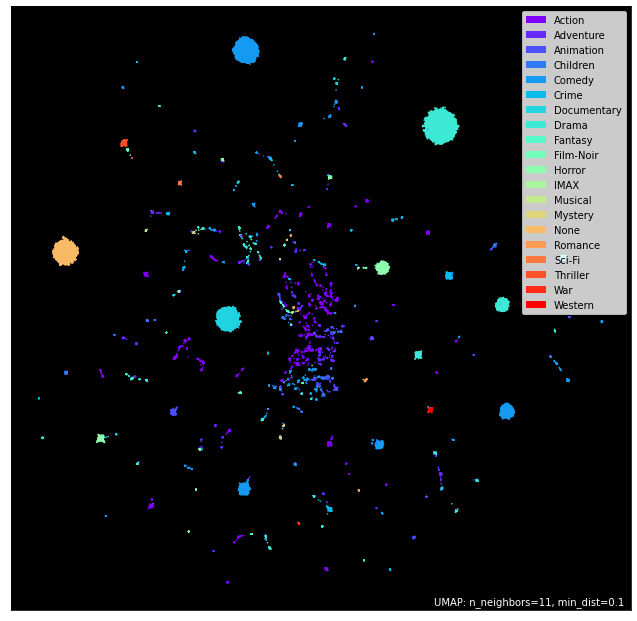

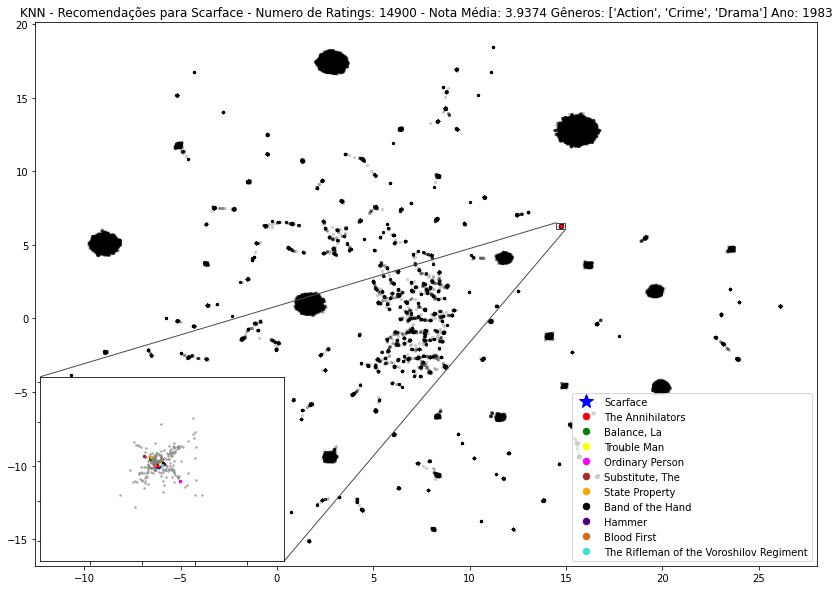

In [103]:
def callRecomendationsAndGraph(movieName, zoom):
    
    #a, b = get_recommendations_genres_cb(movieName, knn_genres_cb, movies_cb)
    a2, b2 = get_recommendations_genres_cb2(movieName, knn_cb2, movies_cb)
    
    print(b2.flatten())
    plotKNN(movieName, movies_cb, a2, b2, zoom)

callRecomendationsAndGraph(movieName, 27)

In [104]:
movies_cb.year.unique()

# year_labels = []
# for row in np.array(sparse_matrix_cb.todense().tolist()): #row[20] == year
#     year_labels.append(str(int(row[20])))
    
# year_labels = np.array(year_labels)


year_labels = np.array(sparse_matrix_cb.getcol(20).todense().tolist()).reshape(1, 62423)[0]

IndexError: index (20) out of range

In [86]:
movies_cb[movies_cb.movieId == 202840]

movieId             title                  genres  year
60233   202840  The Annihilators  [Action, Crime, Drama]  1985

In [44]:
umap.plot.output_notebook()
p = umap.plot.interactive(trans, labels=labels, hover_data=movies_cb, point_size=2)
umap.plot.show(p)

Loading BokehJS ...

In [33]:
len(movies_cb.year.unique())

136